In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists, dirname
from os import makedirs
from itertools import product
from functools import partial
import numpy as np
import pandas as pd

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_local_pcn.builder import load_modules

from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_neural_data

In [4]:
_data_cache = dict()

def get_data_cached(input_size, seed):
    if (input_size, seed) not in _data_cache:
        _data_cache[input_size, seed] = get_data('a', 200, input_size,
                                                 ('042318', '043018', '051018'),
                                                 scale=0.5,
                                                 seed=seed)
    return _data_cache[input_size, seed]

In [5]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/maskcnn_polished_with_local_pcn'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit_certain_configs import param_iterator_obj
from key_utils import keygen

In [6]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [7]:
cc_max_all_neurons.mean(), cc_max_all_neurons.std()

(0.6664160960488147, 0.10090283637801967)

In [8]:
sorted(cc_max_all_neurons)

[0.40454113363846383,
 0.46844836068793605,
 0.47199943055330545,
 0.48975868429591524,
 0.5110353113504426,
 0.5145234425120627,
 0.5219713052270615,
 0.5348103794178967,
 0.5446257845239241,
 0.5492287721163304,
 0.5561048217182305,
 0.5620696910941899,
 0.5622489560516425,
 0.5642971936592102,
 0.565922423361608,
 0.5714186045283002,
 0.5716284942970641,
 0.5742814170955007,
 0.5789620479467756,
 0.5839685774413216,
 0.5869883324894604,
 0.5873337591686838,
 0.587815372092652,
 0.5887748849352052,
 0.5899183800062991,
 0.594183074829996,
 0.602751694243421,
 0.6074175411335863,
 0.6154963706345039,
 0.6193999049751647,
 0.6271345283426643,
 0.6347336409546123,
 0.6570433750036597,
 0.6592252044631914,
 0.6655561206760904,
 0.6681527421760517,
 0.671818347311579,
 0.6748453410247807,
 0.6785014428429974,
 0.681998311359898,
 0.682598435133304,
 0.6830546687138443,
 0.6888893705546542,
 0.69512611850713,
 0.6956020434493437,
 0.7016132747173836,
 0.7019006031581148,
 0.707837776922232

In [9]:
from scipy.stats import pearsonr

def calculate_cc(responses, label):
    assert responses.shape == label.shape
    assert responses.ndim == 2
    assert responses.shape[1] == 79

    corr_each = np.array(
        [
            pearsonr(yhat, y)[0] if np.std(yhat) > 1e-5 and np.std(y) > 1e-5 else 0 for yhat, y in zip(responses.T, label.T)
        ]
    )
    assert corr_each.shape == (79,)
    return corr_each

def calculate_cc2(responses, label):
    ret = calculate_cc(responses, label)**2
    assert ret.shape == (79,)
    return ret 

def calculate_mse(responses, label):
    assert responses.shape == label.shape
    assert responses.ndim == 2
    assert responses.shape[1] == 79
    
    mse_each = np.mean((responses-label)**2, axis=0)
    assert mse_each.shape == (79,)
    return mse_each

def normalize(raw_each, power, method):
    assert raw_each.shape == (79,) == cc_max_all_neurons.shape
    assert type(power) is int and power in {1,2}
    assert method in {'div', 'mul'}
    if method == 'div':
        ret = raw_each/(cc_max_all_neurons**power)
    elif method == 'mul':
        # for mse, intuitively, more inheriently noisy neurons (smaller cc_max) should be discounted for its error.
        ret = raw_each*(cc_max_all_neurons**power)
    else:
        raise ValueError

    assert ret.shape == (79,)
    return ret
    
metric_map = {
    'mse': calculate_mse,
    'cc': calculate_cc,
    'cc2': calculate_cc2,
}

norm_power_map = {
    'mse': {
        # intuitively, more inheriently noisy neurons (smaller cc_max) should be discounted for its error.
        'power': 2,
        'method': 'mul',
    },
    'cc': {
        'power': 1,
        'method': 'div',
    },
    'cc2': {
        'power': 2,
        'method': 'div',
    },
}

In [10]:
def load_everything():
    _df_collect = []
    
    dir_to_save = join(dir_dict['analyses'], 'responses_yuanyuan_8k_a_3day+maskcnn_polished_with_local_pcn+certain_configs')
    for idx, param in enumerate(param_iterator_obj.generate()):
        if idx % 50 == 0:
            print(idx)
            
#         print(len(param))
        
        assert len(param) == 23
        assert param['split_seed'] == 'legacy'
        assert param['out_channel'] == 16
        assert param['num_layer'] == 2
        assert param['kernel_size_l1'] == 9
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)

        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        param_base={
#                 'split_seed': str(param['split_seed']),
                
                
                'act_fn': param['act_fn'],
                'bn_before_act': param['bn_before_act'],
                'bn_after_fc': param['bn_after_fc'],
                'input_size': param['input_size'],
                'loss_type': param['loss_type'],
                
                # 12 to go
                
                'scale': float(param['scale']),
                # 
                'smoothness': float(param['smoothness']),
                # 
                
                # 8 to go
                'pcn_bn': param['pcn_bn'],
                'pcn_bn_post': param['pcn_bn_post'],
                'pcn_bypass': param['pcn_bypass'],
                'pcn_final_act': param['pcn_final_act'],
                'pcn_no_act': param['pcn_no_act'],
                'pcn_bias': param['pcn_bias'],
                
                'pcn_cls': param['pcn_cls'],
                
                'model_seed': param['model_seed'],
            }
        
        datasets = get_data_cached(param['input_size'], param['split_seed'])


        datasets = {
            'X_train': datasets[0].astype(np.float32),
            'y_train': datasets[1],
            'X_val': datasets[2].astype(np.float32),
            'y_val': datasets[3],
            'X_test': datasets[4].astype(np.float32),
            'y_test': datasets[5],
        }
        
        
        
        for subset in (
            # will add train and val later if needed.
#             'train',
#             'val',
            'test',
        ):
            
            file_to_store_this = join(dir_to_save, key, subset + '.npy')
            assert exists(file_to_store_this)
            responses = np.load(file_to_store_this)
        
            # save mse, adjusted mse, corr and adjusted corr, corr^2 and adjusted corr^2
        
            # basically
            # mse, mse_normed, cc, cc_normed, cc2, cc2_normed.
            
            for measure in ('mse', 'cc', 'cc2'):
                raw_metric = metric_map[measure](responses, datasets[f'y_{subset}'])
            
                _df_collect.append({
                    **param_base,
                    **{
                        'subset': subset,
                        'measure': measure,
                        'val': raw_metric.mean(),
                        'val_per': raw_metric,
                    }
                })
                
                
                val_per_normed = normalize(raw_metric, **norm_power_map[measure])
                _df_collect.append({
                    **param_base,
                    **{
                        'subset': subset,
                        'measure': f'{measure}_normed',
                        'val': val_per_normed.mean(),
                        'val_per': val_per_normed
                    }
                })
        

    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'act_fn', 'bn_before_act', 'bn_after_fc',
        'input_size', 'loss_type', 'scale',
        'smoothness',

        'pcn_bn', 'pcn_bn_post', 'pcn_bypass', 'pcn_final_act', 'pcn_no_act', 'pcn_bias', 'pcn_cls',
        'model_seed',

        'subset',
        'measure', 'val', 'val_per'

                                             ])
    _df = _df.set_index([
        'act_fn', 'bn_before_act', 'bn_after_fc',
        'input_size', 'loss_type', 'scale',
        'smoothness',
        'pcn_bn', 'pcn_bn_post', 'pcn_bypass', 'pcn_final_act', 'pcn_no_act', 'pcn_bias', 'pcn_cls',
        'model_seed',
        'subset',
        'measure',
        
    ],verify_integrity=True)
    return _df

In [11]:
metric_pkl_loc = join(
    dir_dict['analyses'],
    'metrics_yuanyuan_8k_a_3day+maskcnn_polished_with_local_pcn+certain_configs.pkl'
)

if not exists(metric_pkl_loc):
    load_everything().to_pickle(metric_pkl_loc)

df_all = pd.read_pickle(metric_pkl_loc)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300


In [12]:
def plot_step_increase(df_this, pairs_to_check, ylim, legacy_selector=False):
    # remove those no innner act ones.
    df_unstacked = df_this.unstack('pcn_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
    if legacy_selector:
        selector = df_unstacked.values[:,0] >= 0.50
        n = selector.sum()
    else:
        selector = ()
        n = df_unstacked.shape[0]
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(len(cls_values)))
    
#     n = df_unstacked.shape[0]
    
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1][selector]
        val1 = df_unstacked.values[:,p2][selector]

        # selection
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
#     plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the PCN block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0.1, 0.625, f'{n} variants', verticalalignment='center', horizontalalignment='left', 
            transform=plt.gca().transAxes)
    fig.subplots_adjust(bottom=0.2)

    plt.show()


(128, 6)
[0, 1, 2, 3, 4, 5]
n 109
1 - 0 mean 0.014380849194660476 sem 0.002370234119044304
2 - 1 mean 0.0022911363012596575 sem 0.0009046559175347874
3 - 2 mean 0.0015608083819281116 sem 0.0008997546199447971
5 - 3 mean 0.004519184389194679 sem 0.0009231438838378051
5 - 2 mean 0.006079992771122791 sem 0.0010863027087669262


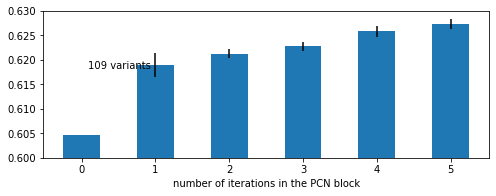

In [13]:
df_mean = df_all['val'].unstack('model_seed').mean(axis=1)
plot_step_increase(df_mean.xs(key='test', level='subset').xs(key='cc2_normed', level='measure'),
                   [(0,1),(1,2),(2,3),(3,5),(2,5)], (0.6, 0.63), legacy_selector=True)

# match 
# results_processed/yuanyuan_8k_a_3day/maskcnn_polished_with_local_pcn/basic_for_certain_configs_cc2normed.ipynb

# (128, 6)
# 0.8515625
# 1 - 0 mean 0.014380849098473241 sem 0.0023702341164843644
# 2 - 1 mean 0.002291137298130233 sem 0.0009046558249784212
# 3 - 2 mean 0.0015608072801898596 sem 0.0008997546343755884
# 5 - 3 mean 0.004519185437958944 sem 0.0009231438633473878
# 5 - 2 mean 0.006079992718148804 sem 0.001086302737924213

(384, 6)
[0, 1, 2, 3, 4, 5]
n 384
1 - 0 mean -0.00033556072423304874 sem 6.891322690022168e-05
2 - 1 mean -3.973337061263795e-05 sem 2.222846600234846e-05
3 - 2 mean -4.575565267079652e-05 sem 2.531285989523367e-05
5 - 3 mean -0.00011064060250444278 sem 2.5704330465420518e-05
5 - 2 mean -0.0001563962551752393 sem 2.8162553871455874e-05


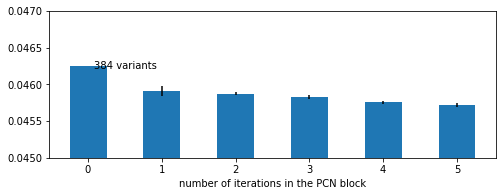

In [14]:
plot_step_increase(
    df_all.xs(key='test', level='subset').xs(key='mse_normed', level='measure')['val'],
    [(0,1),(1,2),(2,3),(3,5),(2,5)], (0.045, 0.047)
)

(384, 6)
[0, 1, 2, 3, 4, 5]
n 384
1 - 0 mean -0.0006878869416276817 sem 0.00014719431346389627
2 - 1 mean -7.848831110445094e-05 sem 4.9262342415291756e-05
3 - 2 mean -8.498190183379485e-05 sem 5.42263929103037e-05
5 - 3 mean -0.00022367938027939528 sem 5.6663438342881296e-05
5 - 2 mean -0.0003086612821131901 sem 6.152684505723134e-05


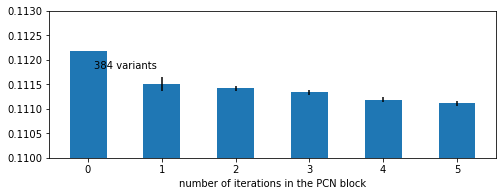

In [15]:
plot_step_increase(
    df_all.xs(key='test', level='subset').xs(key='mse', level='measure')['val'],
    [(0,1),(1,2),(2,3),(3,5),(2,5)], (0.11, 0.113)
)